# ROB2004 Final Project - pick and place objects

The goal of this project is to solve a simple manipulation task: create a tower of cubes.

## Instructions
* Solve the problem below.
* You will need to submit on Brightspace: 
    1. the code you wrote to answer the questions in a Jupyter Notebook. The code should be runnable as is.
    2. a report (maximum 3 pages) in pdf format detailing the methodology you followed to solve the problem. You should add the plots in the report (does not count for the page limit).
* This is an individual project

We will use a model of the Frank-Emika Panda robot. This robot has 7 revolute joints and its kinematics is described in the picture below.

You will need to install pybullet on your computer. Please reach out as soon as possible for help if you do not know how to do it.

<div>
<img src="./panda.jpg" width="200"/>
</div>

# Problem

Implement controller(s) using the code skeletong below to get the robot to build a tower of 3 cubes, with the green cube on the bottom and the blue cube on the top. 

<div>
<img src="./manipulation_scene.jpg" width="400"/>
</div>

You are free to use the methods that you want to solve the task, with the following constraints:
* You cannot use any external library apart from numpy and scipy
* You need to use at least one controller in the end-effector space
* You need to use at least one inverse geometry method
* You need to compensate for the gravity of the robot

In your report, describe the controller(s) and justify your choices. Analyze the behavior of the system (include plots of the end-effector trajectories, velocities, joint trajectories, etc as you see fit).

## Scene details
The position of the red cube in the spatial frame is $(0.35,0.58,0.65)$, the green cube is at $(0.2,0.58,0.65)$ and the blue cube at $(0.0,0.58,0.65)$.


In [1]:
# External Libraries
import numpy as np
import scipy
import matplotlib.pyplot as plt

# My Libraries
from utils import Utils
from task import Task

from panda import Simulator, PandaRobot

np.set_printoptions(precision=4, suppress = True)

pybullet build time: Mar 14 2024 13:49:57


In [2]:
def robot_to_world(pose):
    Twr = np.block([
    [np.identity(3), np.array([[0.0],[0.0],[0.5]])],
    [0.0,0.0,0.0,1.0]
    ])
    return Twr @ pose

def world_to_robot(pose):
    Trw = np.block([
    [np.identity(3), np.array([[0.0],[0.0],[-0.5]])],
    [0.0,0.0,0.0,1.0]
    ])
    return Trw @ pose

In [3]:
tasks = [
    Task("eef",np.array([[-1.0, 0.0, 0.0, 0.35],[0.0, 1.0, 0.0, 0.58],[0.0, 0.0, -1.0, 0.82],[0.0, 0.0, 0.0, 1.0]]),update_text="Picking Red Block"),
    Task("grasp","open"),
    Task("eef",np.array([[-1.0, 0.0, 0.0, 0.35],[0.0, 1.0, 0.0, 0.58],[0.0, 0.0, -1.0, 0.77],[0.0, 0.0, 0.0, 1.0]])),
    Task("grasp","close"),
    Task("eef",np.array([[-1.0, 0.0, 0.0, 0.35],[0.0, 1.0, 0.0, 0.58],[0.0, 0.0, -1.0, 0.90],[0.0, 0.0, 0.0, 1.0]]),update_text="Placing Red Block"),
    Task("eef",np.array([[-1.0, 0.0, 0.0, 0.2],[0.0, 1.0, 0.0, 0.58],[0.0, 0.0, -1.0, 0.90],[0.0, 0.0, 0.0, 1.0]])),
    Task("eef",np.array([[-1.0, 0.0, 0.0, 0.2],[0.0, 1.0, 0.0, 0.58],[0.0, 0.0, -1.0, 0.85],[0.0, 0.0, 0.0, 1.0]])),
    Task("grasp","open"),
    Task("eef",np.array([[-1.0, 0.0, 0.0, 0.2],[0.0, 1.0, 0.0, 0.58],[0.0, 0.0, -1.0, 0.90],[0.0, 0.0, 0.0, 1.0]]),update_text="Picking Blue Block"),
    Task("eef",np.array([[-1.0, 0.0, 0.0, 0.0],[0.0, 1.0, 0.0, 0.58],[0.0, 0.0, -1.0, 0.90],[0.0, 0.0, 0.0, 1.0]])),
    Task("eef",np.array([[-1.0, 0.0, 0.0, 0.0],[0.0, 1.0, 0.0, 0.58],[0.0, 0.0, -1.0, 0.77],[0.0, 0.0, 0.0, 1.0]])),
    Task("grasp","close"),
    Task("eef",np.array([[-1.0, 0.0, 0.0, 0.0],[0.0, 1.0, 0.0, 0.58],[0.0, 0.0, -1.0, 0.95],[0.0, 0.0, 0.0, 1.0]]),update_text="Placing Blue Block"),
    Task("eef",np.array([[-1.0, 0.0, 0.0, 0.2],[0.0, 1.0, 0.0, 0.58],[0.0, 0.0, -1.0, 0.95],[0.0, 0.0, 0.0, 1.0]])),
    Task("eef",np.array([[-1.0, 0.0, 0.0, 0.2],[0.0, 1.0, 0.0, 0.58],[0.0, 0.0, -1.0, 0.90],[0.0, 0.0, 0.0, 1.0]])),
    Task("grasp","open"),
    Task("eef",np.array([[-1.0, 0.0, 0.0, 0.2],[0.0, 1.0, 0.0, 0.58],[0.0, 0.0, -1.0, 1.0],[0.0, 0.0, 0.0, 1.0]]),update_text="Done! Going to initial pose")
]  

In [4]:
# Creating robot object and simulation
simulator = Simulator()
simulator.reset_state([0.,0,0.0,-np.pi/2.,0.,np.pi/2.,0.0])
my_robot = PandaRobot()

# Configs
run_time = 30.
dt = 0.0001
num_steps = int(run_time/dt)
ndofs = 7
time = np.zeros([num_steps])

# Task Initialization
task_index = 0
holding = 0
print("Update: ", tasks[0].update_text)

# Logging
q_p_logs = np.zeros((num_steps,7))
q_v_logs = np.zeros((num_steps,7))
eef_p_logs = np.zeros((num_steps,3))
eef_v_logs = np.zeros((num_steps,3))
eef_w_logs = np.zeros((num_steps,3))

# Control Loop
for i in range(num_steps):
    # Getting the current time
    time[i] = dt * i
    if task_index >= len(tasks):
        break
    task = tasks[task_index]

    # Getting the current joint positions/velocities
    q, dq = simulator.get_state()

    match task.type:

        case"eef":

            # EEF Jacobian in Body Space
            J = my_robot.get_jacobian(q, 'B')

            # Task Information
            desired_pose_world =  task.goal
            desired_pose = world_to_robot(desired_pose_world)
            P = task.P*np.identity(6)
            D = task.D*np.identity(6)

            # Measured EEF Pose/Twist
            measured_pose = my_robot.FK(q)
            measured_twist = J@dq
            
            # Computed Pose Error (as twist)                 
            delta_poses = Utils.inverse_homogeneous_matrix(measured_pose) @ desired_pose
            pose_error = Utils.transformation_to_twist(delta_poses).squeeze()
            
            # Computed Twist Error        
            reference_twist = np.zeros(6)
            twist_error = reference_twist - measured_twist

            # Positional Error to Stop Changing
            if np.all(abs(pose_error) < task.max_error):
                task_index = task_index + 1
                if task_index<len(tasks) and  tasks[task_index].update_text != None:
                    print("Update: ", tasks[task_index].update_text)
                continue

            # Impedence Control
            joint_torques = J.T @ ( P @ pose_error + D@ twist_error) + my_robot.g(q)
            if holding:
                joint_torques += J.T @ np.array([0.0,0.0,0.0,0.0,0.0,-0.981])

            simulator.send_joint_torque(joint_torques)

        
        case "grasp":

            if task.goal=="open":
                holding = 0
                simulator.gripper_move([0.04,0.04])
            elif task.goal=="close":
                holding = 1
                simulator.gripper_move([0.0,0.0])

            task_index = task_index + 1
            if task_index<len(tasks) and tasks[task_index].update_text != None:
                    print("Update: ", tasks[task_index].update_text)
    
    # Logging the eef/joints positions/velocities
    q_p_logs[i] = q
    q_v_logs[i] = dq
    eef_p_logs[i] = robot_to_world(my_robot.FK(q))[0:3,3]
    eef_v_logs[i] = (my_robot.get_jacobian(q,'B')@dq)[3:6]
    eef_w_logs[i] = (my_robot.get_jacobian(q,'B')@dq)[0:3]

    # Stepping the simulator
    simulator.step()

2024-04-27 18:59:28.119 Python[85957:936579] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


Version = 4.1 Metal - 88
Vendor = Apple
Renderer = Apple M1
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
Update:  Picking Red Block
Update:  Placing Red Block
Update:  Picking Blue Block
Update:  Placing Blue Block
Update:  Done! Going to initial pose


**Plotting the Joints Positions/Velocities**

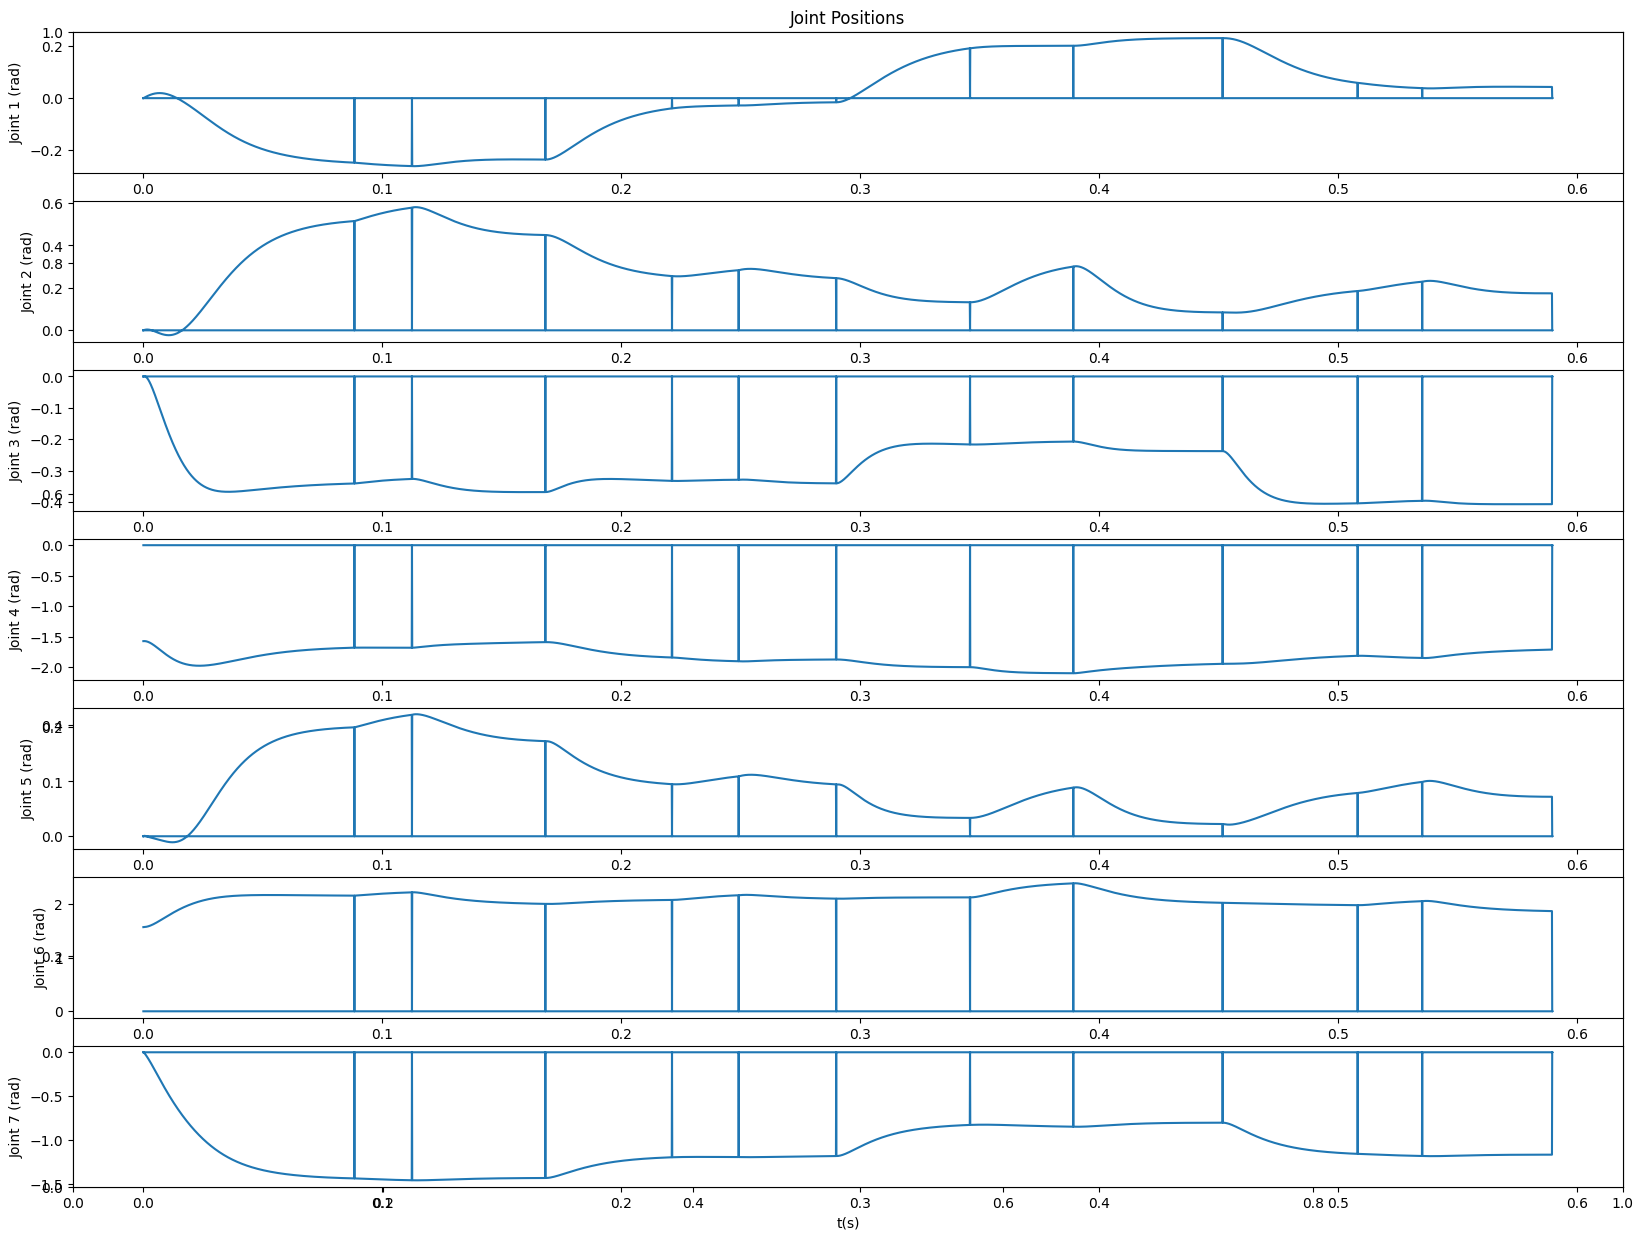

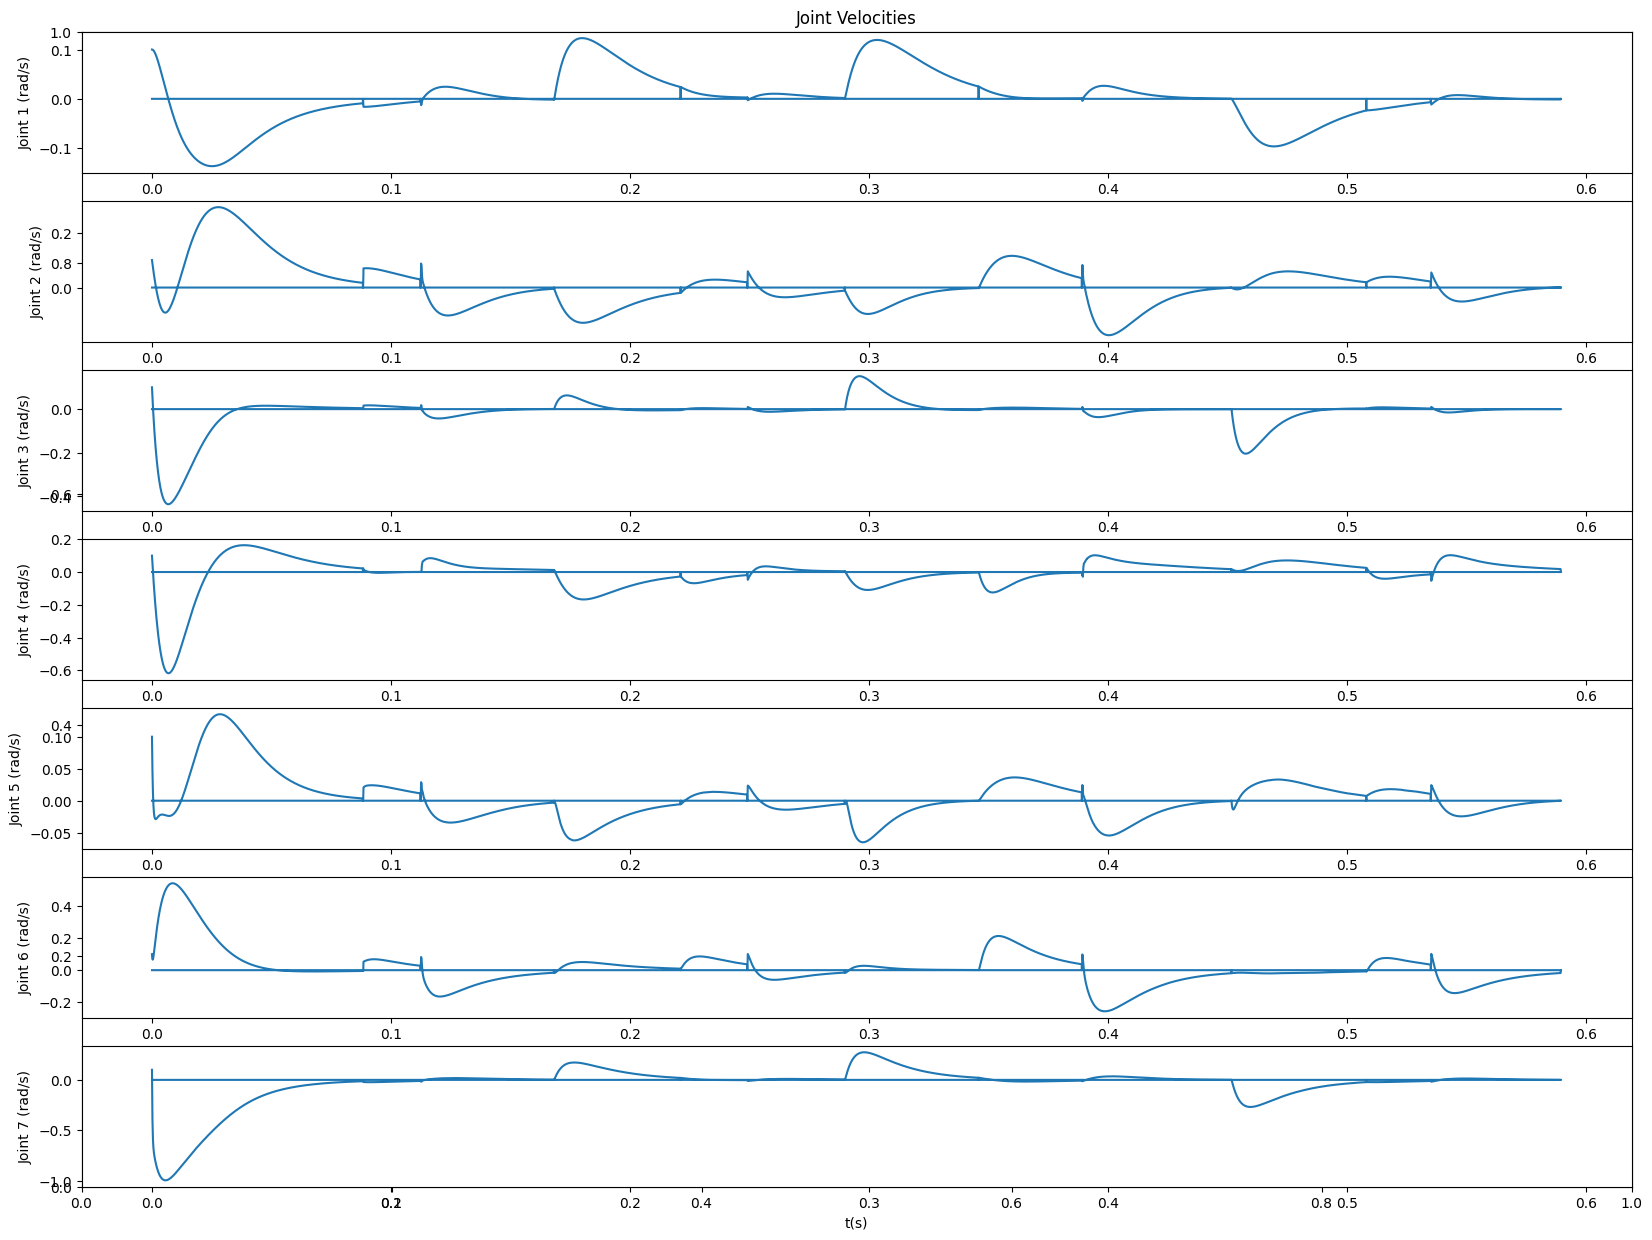

In [37]:
plt.figure(figsize=(20,15))
plt.title("Joint Positions")
for i in range(ndofs):
    plt.subplot(ndofs,1,i+1)
    plt.plot(time,q_p_logs[:,i])
    plt.xlabel("t(s)")
    plt.ylabel("Joint " + str(i+1) + " (rad)")

plt.figure(figsize=(20,15))
plt.title("Joint Velocities")
for i in range(ndofs):
    plt.subplot(ndofs,1,i+1)
    plt.plot(time,q_v_logs[:,i])
    plt.xlabel("t(s)")
    plt.ylabel("Joint " + str(i+1) + " (rad/s)")


**Plotting End-Effector Positions/Velocities**

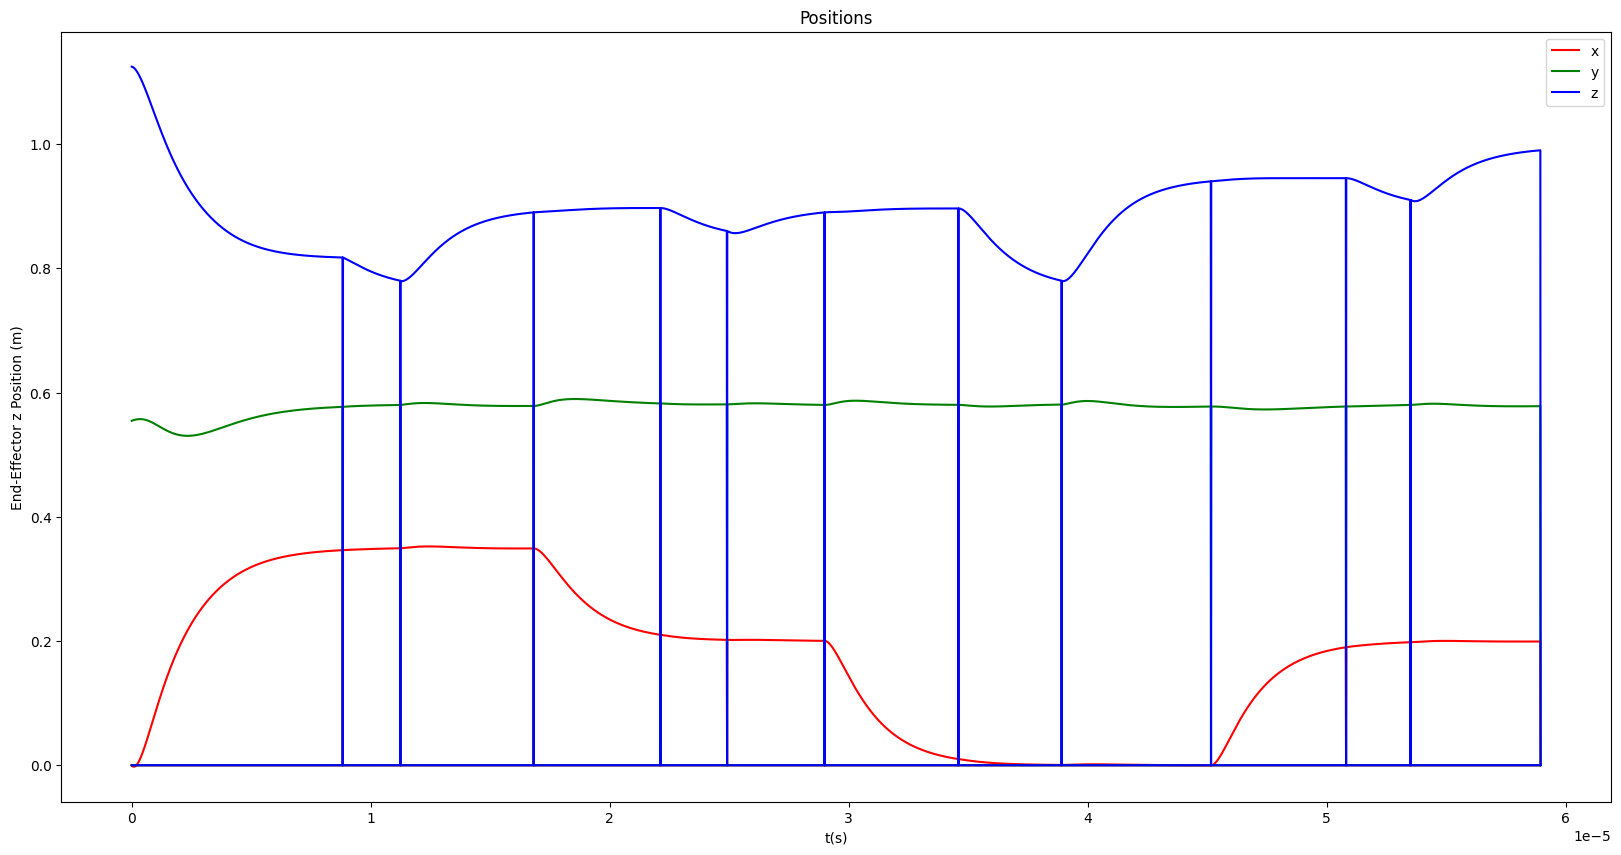

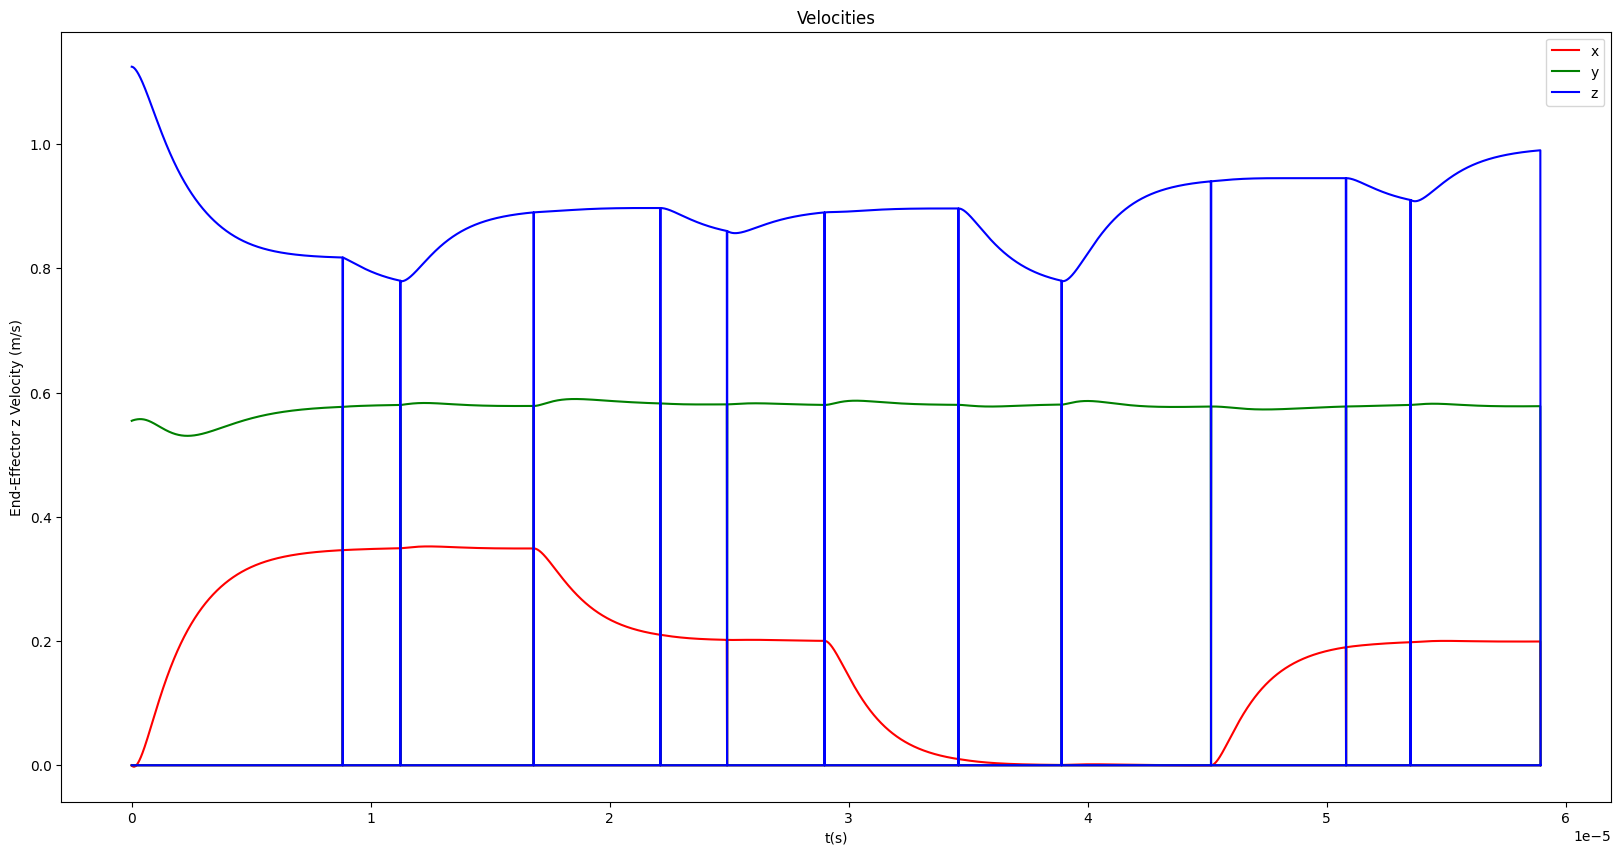

In [46]:
plt.figure(figsize=(20,10))
plt.title("Positions")
labels = ["x","y","z"]
colors = ["r","g","b"]
for i in range(3):
    plt.plot(time*dt,eef_p_logs[:,i],colors[i])
    plt.xlabel("t(s)")
    plt.ylabel("End-Effector " + labels[i] + " Position (m)")
    plt.legend(labels)

plt.figure(figsize=(20,10))
plt.title("Velocities")
labels = ["x","y","z"]
colors = ["r","g","b"]
for i in range(3):
    plt.plot(time*dt,eef_p_logs[:,i],colors[i])
    plt.xlabel("t(s)")
    plt.ylabel("End-Effector " + labels[i] + " Velocity (m/s)")
    plt.legend(labels)

